# take all the appa's data(11y), find the season polyline and normalize the data

In [337]:
import math
import locale
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb, rgb_to_hsv, hsv_to_rgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
import datetime as dt
from sklearn import model_selection
from sklearn import svm
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from joblib import dump, load
#from tqdm.notebook import trange, tqdm
import pickle

STATION = "Parco S. Chiara"
pollu = ["Biossido di Azoto", "Ossido di Carbonio", "PM10", "Ozono", "PM2.5", "Biossido Zolfo"]
POLLUTANT = pollu[5]

In [338]:
ds = pd.read_csv('data/APPA_data_merged.csv')
ds.Data = pd.to_datetime(ds.Data, format = "%Y-%m-%d %H:%M:%S")
ds.Valore = ds.Valore.map(lambda x: int(x))

In [339]:
ds.value_counts(ds.Inquinante == POLLUTANT)

Inquinante
False    2186245
True       92513
dtype: int64

In [340]:
ds = ds[ds.Inquinante == POLLUTANT]
ds = ds[ ds.Stazione == STATION]

In [341]:
fig_all= px.scatter(y="Valore",x="Data",data_frame=ds[ds.Data.dt.date == ds.iloc[500].Data.date()])
fig_all.show()

In [342]:
ds_day = ds.set_index("Data")
ds_day = ds_day.resample("d").sum()
ds_day = ds_day.reset_index(level=0)

In [343]:
ds = ds.set_index("Data").resample("H").mean().reset_index(level=0)

In [344]:
ds.insert(2,"day_of_year",ds.Data.map(lambda x: x.dayofyear),True)
ds_day.insert(2,"day_of_year",ds_day.Data.map(lambda x: x.dayofyear),True)

In [345]:
fig_all= px.scatter(y="Valore",x="Data",data_frame=ds)
fig_all.show()

In [346]:
fig_all= px.scatter(y="Valore",x="day_of_year",data_frame=ds_day)
fig_all.show()

In [347]:
plt.xkcd(scale=0.5)

p = sns.color_palette("colorblind")

TRUE_COLOR = p[1]
SAMPLES_COLOR = p[0]  #"steelblue"
POLY_3_COLOR = p[2]  #"darkorange"
POLY_15_COLOR = p[3]  #"darkgreen"
TRAIN_COLOR = p[4]  #"crimson"
TEST_COLOR = p[5]  #"darkolivegreen"


def true_fun(x):
    return np.cos(1.5 * np.pi * x)

def poly_fit(X, y, degree):
    pipeline = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression(),
    )
    pipeline.fit(X, y)
    return pipeline

def start_plot():
    fig, ax = plt.subplots(constrained_layout=True)
    return fig, ax

def finalise_plot(ax):
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((-60, 400))
    ax.set_ylim((-2, 2500))
    ax.legend(loc="best")

def plot_model(ax, model, color, label="Model"):
    X_test = np.linspace(-60, 400, 50000)[:, np.newaxis]
    y_pred = model.predict(X_test)
    ax.plot(X_test, y_pred, label=label, color=color, linestyle="--")

def plot_true(ax):
    X_test = np.linspace(0, 366, 10000)[:, np.newaxis]
    ax.plot(X_test, true_fun(X_test), label="True function", color=TRUE_COLOR)

def plot_samples(ax, X, y, label, color):
    edgecolor = hsv_to_rgb(rgb_to_hsv(to_rgb(color)) * [1.0, 0.9, 1.0])
    ax.scatter(X, y, edgecolor=edgecolor, facecolor=color, s=2, label=label, zorder=100)

In [348]:
ext_ds = ds_day
ext_ds = ds_day.append(ds_day[ds_day.day_of_year>300].assign(day_of_year=lambda x:x['day_of_year']-366))
ext_ds = ext_ds.append(ds_day[ds_day.day_of_year<60][ds_day.day_of_year>0].assign(day_of_year=lambda x:x['day_of_year']+366))

C:\Users\samue\AppData\Local\Temp\ipykernel_15128\2059438224.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\samue\AppData\Local\Temp\ipykernel_15128\2059438224.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\samue\AppData\Local\Temp\ipykernel_15128\2059438224.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [349]:
fig_all= px.scatter(y="Valore",x="day_of_year",data_frame=ext_ds)
fig_all.show()

In [350]:
X_fit = ext_ds.day_of_year[:,np.newaxis]
y_fit = ext_ds.Valore

C:\Users\samue\AppData\Local\Temp\ipykernel_15128\2418346623.py:1: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



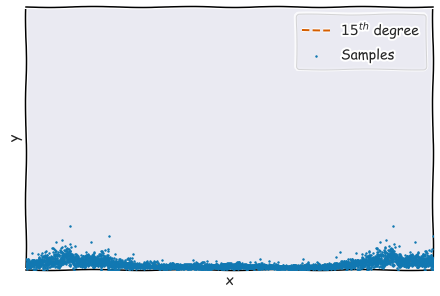

In [351]:
model = poly_fit(X_fit, y_fit, 5)

fig, ax = start_plot()
plot_model(ax, model, POLY_15_COLOR, "$15^{th}$ degree")

plot_samples(ax, X_fit, y_fit, "Samples", SAMPLES_COLOR)
finalise_plot(ax)

In [352]:
ds_norm = ds_day
ds_norm.insert(3,"norm_value",ds_norm.Valore - model.predict(ds_norm.day_of_year[:,np.newaxis]))
ds_norm.insert(4,"prediction",model.predict(ds_norm.day_of_year[:,np.newaxis]))

C:\Users\samue\AppData\Local\Temp\ipykernel_15128\2535405201.py:2: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\samue\AppData\Local\Temp\ipykernel_15128\2535405201.py:3: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [353]:
dump(model, f'models/{POLLUTANT}.joblib')
pickle.dump(model, open(f'models/{POLLUTANT}.sav', 'wb'))

In [ ]:
fig_all= px.scatter(y="norm_value",x="Data",data_frame=ds_norm, trendline="ols", trendline_color_override="white")
fig_all.show()
px.get_trendline_results(fig_all).px_fit_results.iloc[0].summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5641
Date:                Tue, 02 Aug 2022   Prob (F-statistic):              0.453
Time:                        12:00:18   Log-Likelihood:                -25865.
No. Observations:                3842   AIC:                         5.173e+04
Df Residuals:                    3840   BIC:                         5.175e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7001      3.276      0.214      0.831      -5.723       7.123
x1            -1.9848      2.643     -0.751      0.453      -7.166       3.196
==============================================================================
Omnibus:                     1816.966   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20750.084
Skew:                           1.959   Prob(JB):                         0.00
Kurtosis:                      13.690   Cond. No.                         1.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#ds_norm = ds_norm.set_index("Data").resample("H").ffill()


In [ ]:
ds_norm = ds_norm.reset_index(level=0)
ds_norm

index       Data  Valore  day_of_year  norm_value  prediction
0         0 2012-01-01     768            1  262.157132  505.842868
1         1 2012-01-02     776            2  269.939906  506.060094
2         2 2012-01-03     363            3 -143.205470  506.205470
3         3 2012-01-04     466            4  -40.280264  506.280264
4         4 2012-01-05     314            5 -192.285735  506.285735
...     ...        ...     ...          ...         ...         ...
3837   3837 2022-07-04     281          185   47.604875  233.395125
3838   3838 2022-07-05     136          186  -97.207499  233.207499
3839   3839 2022-07-06     180          187  -53.047901  233.047901
3840   3840 2022-07-07     229          188   -3.916299  232.916299
3841   3841 2022-07-08      11          189 -221.812657  232.812657

[3842 rows x 6 columns]

to_drop = []
index_drop = []
for line in tqdm(ds_norm.iterrows(), total = ds.shape[0]):
    if ds[ds.Data == line[1].Data].empty:
        #print(line[0])
        #to_drop.append(line[1].Data)
        index_drop.append(line[0])


index_drop = [x for x in index_drop]

ds.drop(index_drop,axis=0,inplace=True)

In [ ]:
ds_norm.insert(5,"relaxion_norm",ds_norm.norm_value / ds_norm.Valore)
# ds.insert(5,"norm_value",ds_norm[ds_norm.Data.dt.date == ds.Data.dt.date].relaxion_norm * ds.Valore)
ds.insert(3,"norm_value",np.NaN)

In [ ]:

for i, line in tqdm(ds.iterrows(), total=ds.shape[0]):
    date_query = line.Data.date()
    #coef = ds_norm[ds_norm.Data.dt.date == date_query].relaxion_norm
    predi = ds_norm[ds_norm.Data.dt.date == date_query].prediction
    ds.at[i,'norm_value'] = line.Valore / predi

 31%|███       | 28500/92184 [01:23<03:06, 340.68it/s]


KeyboardInterrupt: 

In [ ]:
fig= px.scatter(y="norm_value",x="Data",data_frame=ds)
fig.show()

In [ ]:
fig_all= px.scatter(y="norm_value",x="Data",data_frame=ds[ds.Data.dt.date == ds.iloc[500].Data.date()])
fig_all.show()

In [ ]:
# out = None
if isinstance(out, type(None)):
    out = pd.read_csv("data/normalized_schaira_appa1_2.csv")
    #out = ds[["Data","norm_value"]].copy()
    #out = out.rename(columns={"Data": "ts","norm_value": POLLUTANT}, errors="raise")
else:
    out[POLLUTANT] = ds["norm_value"]

In [ ]:
out.index = np.arange(1, len(out)+1)
out.to_csv("data/normalized_schaira_appa1_2.csv")